# Fake news detection on tweets using the PHEME dataset

This notebook is an extension of the Fake News Detection notebook.

Its aim is helping us understand the importance of each useful feature of the tweet for our task, fake news detection. To do so we have implemented the [Shapely value](https://en.wikipedia.org/wiki/Shapley_value) techinque ([here](https://christophm.github.io/interpretable-ml-book/shapley.html) a longer but more clear explanation, for the ones like me that sometimes don't understand anything in a Wiki page), using the [Shap library](https://shap.readthedocs.io/en/latest/index.html).

The dataset can be downloaded here: https://figshare.com/articles/dataset/PHEME_dataset_for_Rumour_Detection_and_Veracity_Classification/6392078


This dataset contains a collection of Twitter rumours and non-rumours posted during breaking news. More specifically, it contain Twitter conversation threads associated with different newsworthy events including the Ferguson unrest, the shooting
at Charlie Hebdo, the shooting in Ottawa, the hostage situation in Sydney and the crash of a Germanwings
plane, and others.


The data is structured as follows. Each event has a directory, with two subfolders, rumours and non-rumours. These two folders have folders named with a tweet ID. The tweet itself can be found on the 'source-tweet' directory of the tweet in question, and the directory 'reactions' has the set of tweets responding to that source tweet. Also each folder contains ‘annotation.json’ which contains information about veracity of the rumour and ‘structure.json’, which contains information about structure of the conversation.
*Notice that, for our task, fake news detection, we used only the tweets classified as rumours in the dataset.*

In [2]:
import numpy as np 
import pandas as pd 
import scipy.stats as stats
import os
import json
import shap
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

2022-08-03 20:13:37.952165: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from sklearn import preprocessing

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [4]:
#going to our dataset directory
%cd ../input/pheme-dataset/all-rnr-annotated-threads_1

/kaggle/input/pheme-dataset/all-rnr-annotated-threads_1


In [5]:
# seed initialization
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# set the folders to iterate on
folds= ['charliehebdo-all-rnr-threads','ottawashooting-all-rnr-threads',
'ebola-essien-all-rnr-threads','prince-toronto-all-rnr-threads',
'ferguson-all-rnr-threads',	'putinmissing-all-rnr-threads',
'germanwings-crash-all-rnr-threads',
'gurlitt-all-rnr-threads','sydneysiege-all-rnr-threads']

fav_counts = []
retweet_counts = []
date = []

username = []
account_date = []
protected = []
verified = []
followers = []
followings = []
tweets_count = []

hashtag = []
url = []

events = []
y = []

In [7]:
# the annotations on PHEME have 2 boolean values, 'misinformation' value and 'true' value, we want to convert them in a single label with values
# 'true', 'false' or 'unverified'. This values can be string or numerical, depending on the 'string' parameter of the function
def convert_annotations_data(annotation, string = True):
    if 'misinformation' in annotation.keys() and 'true'in annotation.keys():
        if int(annotation['misinformation'])==0 and int(annotation['true'])==0:
            if string:
                label = "unverified"
            else:
                label = 2
        elif int(annotation['misinformation'])==0 and int(annotation['true'])==1 :
            if string:
                label = "true"
            else:
                label = 1
        elif int(annotation['misinformation'])==1 and int(annotation['true'])==0 :
            if string:
                label = "false"
            else:
                label = 0
        elif int(annotation['misinformation'])==1 and int(annotation['true'])==1:
            print ("OMG! They both are 1!")
            print(annotation['misinformation'])
            print(annotation['true'])
            label = None
            
    elif 'misinformation' in annotation.keys() and 'true' not in annotation.keys():
        # all instances have misinfo label but don't have true label
        if int(annotation['misinformation'])==0:
            if string:
                label = "unverified"
            else:
                label = 2
        elif int(annotation['misinformation'])==1:
            if string:
                label = "false"
            else:
                label = 0
                
    elif 'true' in annotation.keys() and 'misinformation' not in annotation.keys():
        print ('Has true not misinformation')
        label = None
    else:
        print('No annotations')
        label = None
           
    return label

In [8]:
# navigate the folders to create our dataset. In our task we only use the tweets that are rumours
for f in folds:
  path1 = os.path.join(f, 'rumours')
  for dir1 in os.listdir(path1):
        if '_' not in dir1:
          path_target  = os.path.join(path1,dir1,'annotation.json')
          file = open(path_target)
          data = json.load(file)
          target = convert_annotations_data(data)
          y.append(target)
          path2 = os.path.join(path1, dir1,'source-tweets')
          for dir2 in os.listdir(path2):
            if '_' not in dir2:
              path3  = os.path.join(path2,dir2)
              file = open(path3)
              data = json.load(file)
            
              #tweet features
              tweet_date = data['created_at']
              fav = data['favorite_count']
              retw = data['retweet_count']
                
              #user features
              usernames = data['user']['screen_name']
              account_creation = data['user']['created_at']
              is_protected = data['user']['protected']
              is_verified = data['user']['verified']
              no_followers = data['user']['followers_count']
              no_followings = data['user']['friends_count']
              no_tweets = data['user']['statuses_count']
                
              #entities
              no_hashtags = len(data['entities']['hashtags'])      
              has_url = data['entities']['urls']  
              text = data['text']
              fav = data['favorite_count']
              retw = data['retweet_count']
              
              date.append(tweet_date)
              fav_counts.append(fav)
              retweet_counts.append(retw)
                                     
              username.append(usernames)
              account_date.append(account_creation)
              protected.append(is_protected)
              verified.append(is_verified)
              followers.append(no_followers)
              followings.append(no_followings)
              tweets_count.append(no_tweets)
            
              
              hashtag.append(no_hashtags)
              url.append(has_url)
            
              events.append(f)

In [9]:
df = pd.DataFrame([date,fav_counts,retweet_counts,username,account_date,followers,followings,tweets_count,protected,verified,hashtag,url,events,y],['date','fav_count','retweet_count','username','account_date','followers','followings','tweet_count','protected','verified','no_hashtags','urls','event','target']).transpose()
df = df.infer_objects()
df.head()

,date,fav_count,retweet_count,username,account_date,followers,followings,tweet_count,protected,verified,no_hashtags,urls,event,target
0,Wed Jan 07 11:24:35 +0000 2015,7,196,EricWRandolph,Tue Jul 13 10:26:28 +0000 2010,2064,829,3806,False,False,2,[],charliehebdo-all-rnr-threads,true
1,Thu Jan 08 00:25:53 +0000 2015,18,107,AFP,Tue Sep 27 00:35:10 +0000 2011,297225,482,64514,False,True,3,"[{'url': 'http://t.co/5NoNuqJSu1', 'indices': ...",charliehebdo-all-rnr-threads,true
2,Wed Jan 07 11:26:38 +0000 2015,33,279,WSJ,Sun Apr 01 06:22:13 +0000 2007,5577526,974,104493,False,True,0,"[{'url': 'http://t.co/tYCeEMKwOo', 'indices': ...",charliehebdo-all-rnr-threads,true
3,Wed Jan 07 12:55:41 +0000 2015,62,339,Independent,Sun Oct 26 00:00:29 +0000 2008,969090,1763,123741,False,True,1,"[{'url': 'http://t.co/4wugwxfVjj', 'indices': ...",charliehebdo-all-rnr-threads,false
4,Fri Jan 09 08:43:56 +0000 2015,24,119,AJEnglish,Tue Apr 17 08:23:08 +0000 2007,2235125,139,134814,False,True,1,"[{'url': 'http://t.co/SIQeukZutl', 'indices': ...",charliehebdo-all-rnr-threads,unverified


In [10]:
df.describe(include = 'all')

,date,fav_count,retweet_count,username,account_date,followers,followings,tweet_count,protected,verified,no_hashtags,urls,event,target
count,2402,2402.000000,2402.000000,2402,2402,2.402000e+03,2402.000000,2402.000000,2402,2402,2402.000000,2402,2402,2402
unique,2369,NaN,NaN,1028,1024,NaN,NaN,NaN,1,2,NaN,1218,9,3
top,Mon Nov 24 10:14:41 +0000 2014,NaN,NaN,BBCBreaking,Sun Apr 22 14:42:37 +0000 2007,NaN,NaN,NaN,False,True,NaN,[],sydneysiege-all-rnr-threads,true
freq,4,NaN,NaN,61,61,NaN,NaN,NaN,2402,1420,NaN,1172,522,1067
mean,NaN,110.992923,272.502914,NaN,NaN,1.551462e+06,3512.940466,58593.058285,NaN,NaN,0.922981,NaN,NaN,NaN
std,NaN,1434.391369,878.958976,NaN,NaN,3.730270e+06,15721.733002,63420.171652,NaN,NaN,0.952157,NaN,NaN,NaN
min,NaN,0.000000,1.000000,NaN,NaN,4.000000e+00,0.000000,4.000000,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,15.000000,102.000000,NaN,NaN,9.306750e+03,308.000000,11978.250000,NaN,NaN,0.000000,NaN,NaN,NaN
50%,NaN,38.000000,148.000000,NaN,NaN,1.086440e+05,643.000000,36661.500000,NaN,NaN,1.000000,NaN,NaN,NaN
75%,NaN,84.000000,259.750000,NaN,NaN,8.434690e+05,1644.000000,96004.750000,NaN,NaN,1.000000,NaN,NaN,NaN


In [11]:
df.shape

(2402, 14)

In [12]:
df.dtypes

date             object
fav_count         int64
retweet_count     int64
username         object
account_date     object
followers         int64
followings        int64
tweet_count       int64
protected          bool
verified           bool
no_hashtags       int64
urls             object
event            object
target           object
dtype: object

In [13]:
df.isnull().sum()

date             0
fav_count        0
retweet_count    0
username         0
account_date     0
followers        0
followings       0
tweet_count      0
protected        0
verified         0
no_hashtags      0
urls             0
event            0
target           0
dtype: int64

In [14]:
# check the features variance
var=df.var().sort_values(ascending=True)
variances = pd.DataFrame({'Variance' :var})
variances.head(8)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Variance
protected,0.000000e+00
verified,2.417880e-01
no_hashtags,9.066020e-01
retweet_count,7.725689e+05
fav_count,2.057479e+06
followings,2.471729e+08
tweet_count,4.022118e+09
followers,1.391492e+13


In [15]:
# drop categorical data and protected which has 0 var
df.drop(["date","username","account_date","urls","protected"], axis=1, inplace=True)

In [16]:
#convert boolen features into numerical
df = df.astype({"verified":'int64'})
df.dtypes

fav_count         int64
retweet_count     int64
followers         int64
followings        int64
tweet_count       int64
verified          int64
no_hashtags       int64
event            object
target           object
dtype: object

**Notice**: In this version **we do not use text as input**. It's possible to implement both text and static features in a Shap explainer, but not with the archtecture that we built.

In [17]:
 def build_model(static_input_shape):
    

    #Static Single Layer Percetron
    static_input = tfkl.Input(static_input_shape,name = "Static_Input")
    static_layer1 = Dense(64,  kernel_regularizer=tfk.regularizers.L2(0.001),  activation='relu',name="Static_dense_1")(static_input)

    #RNN + Static
    combined = tfkl.Concatenate(axis= 1,name = "Concatenated")([static_layer1])
    combined_dense1 = Dense(64, activation='relu',name="Combined_dense1")(combined)

    output_layer = Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotNormal(seed), name='Output')(combined_dense1)

    #Compile model
    model = Model(inputs=[static_input],outputs=[output_layer], name = "Megazord_Model")
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    
    #to reduce verbosity we comment this
    #print(model.summary())
    return model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callback = EarlyStopping(monitor='val_loss', patience=10)
# model.fit(callbacks=[early_stopping_callback, Checkpointer])

In [18]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [19]:
column_names = ['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']

2022-08-03 20:13:46.479489: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1


model using as test set:  charliehebdo-all-rnr-threads
size of the test set:  4122


2022-08-03 20:13:46.515204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 20:13:46.515837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-08-03 20:13:46.515952: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-03 20:13:46.516034: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-03 20:13:46.516074: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-03 20:13:46.516113: I tensorflow/stream_executor

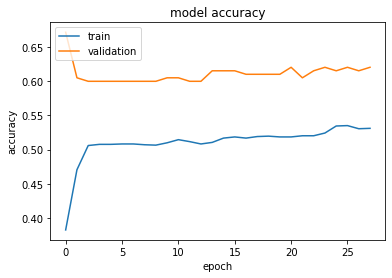

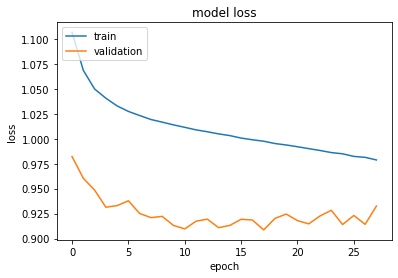

10/10 [==============================] - 0s 2ms/step - loss: 1.1929 - accuracy: 0.3344


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


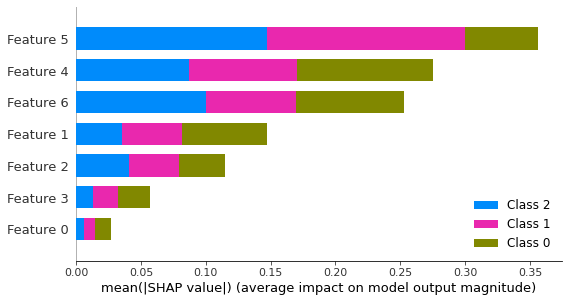

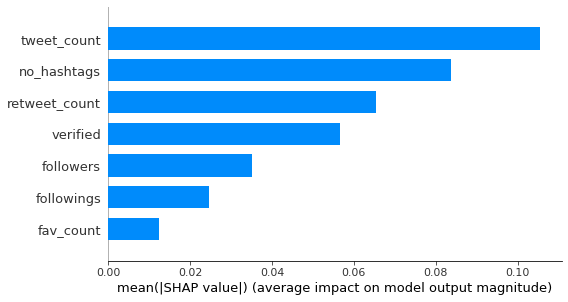

model using as test set:  ottawashooting-all-rnr-threads
size of the test set:  4230


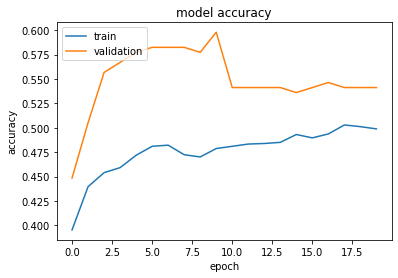

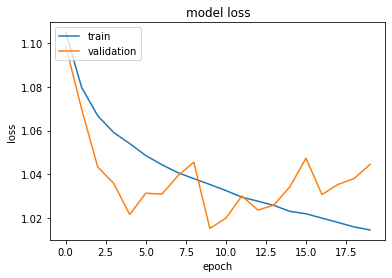

11/11 [==============================] - 0s 2ms/step - loss: 1.1266 - accuracy: 0.4407


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


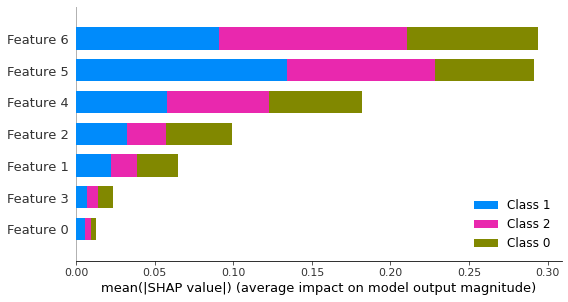

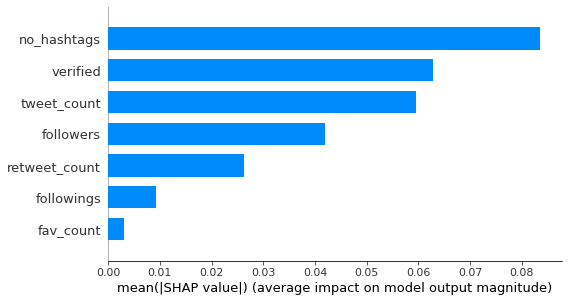

model using as test set:  ebola-essien-all-rnr-threads
size of the test set:  126


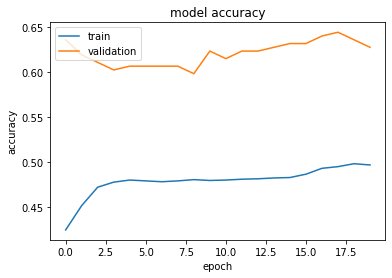

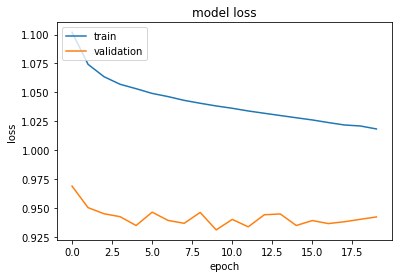

1/1 [==============================] - 0s 16ms/step - loss: 1.5406 - accuracy: 0.3333


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


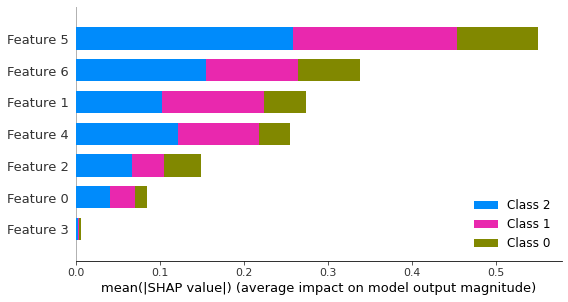

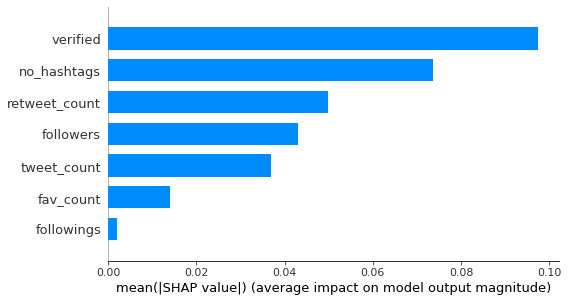

model using as test set:  prince-toronto-all-rnr-threads
size of the test set:  2061


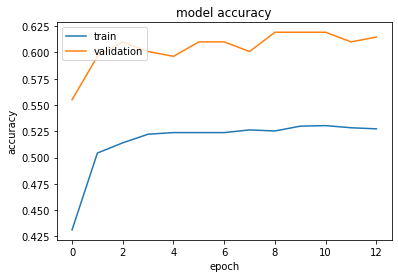

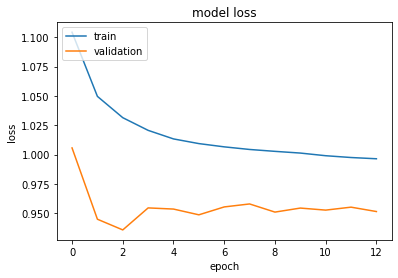

5/5 [==============================] - 0s 3ms/step - loss: 1.6996 - accuracy: 0.0000e+00


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


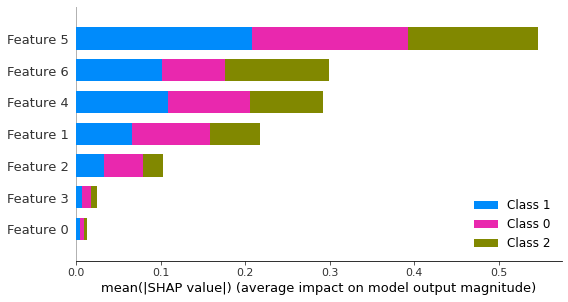

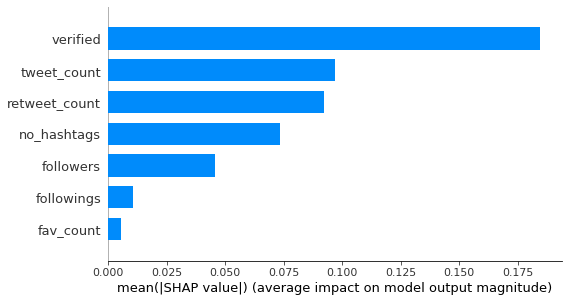

model using as test set:  ferguson-all-rnr-threads
size of the test set:  2556


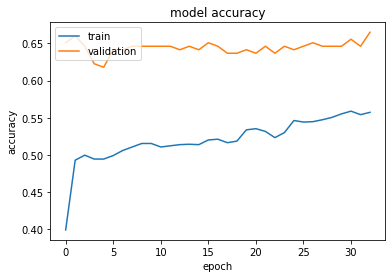

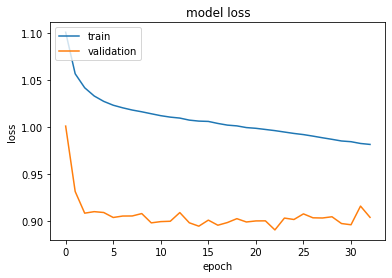

7/7 [==============================] - 0s 6ms/step - loss: 1.5635 - accuracy: 0.1212


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


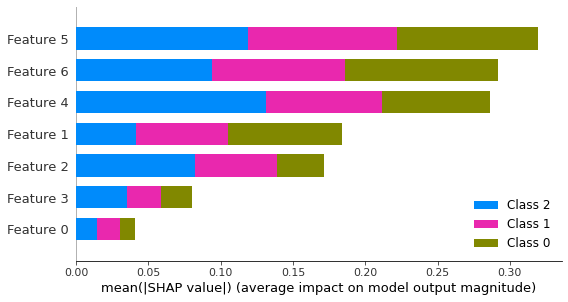

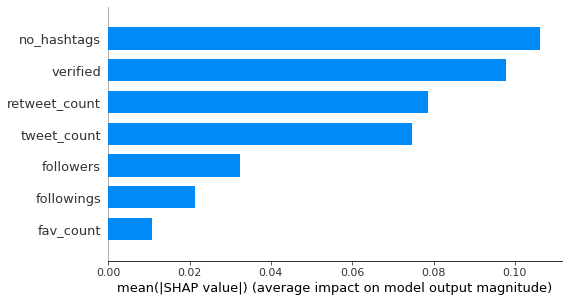

model using as test set:  putinmissing-all-rnr-threads
size of the test set:  1134


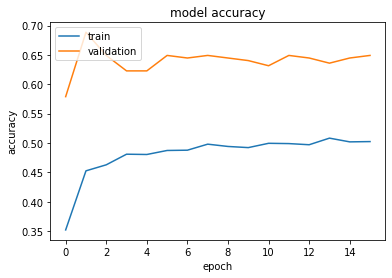

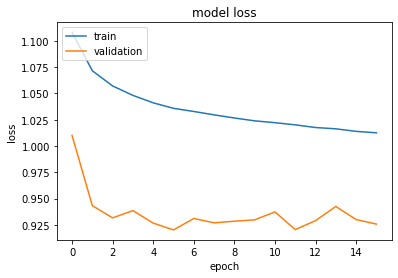

3/3 [==============================] - 0s 3ms/step - loss: 1.6246 - accuracy: 0.1932


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


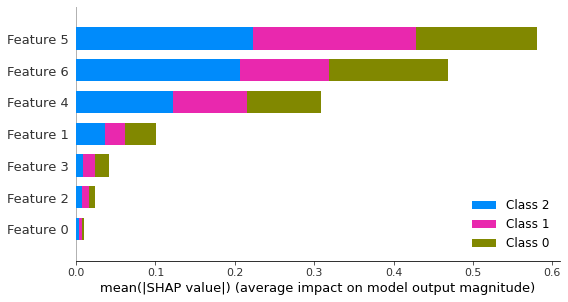

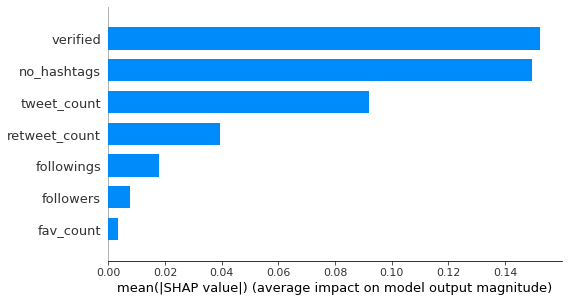

model using as test set:  germanwings-crash-all-rnr-threads
size of the test set:  2142


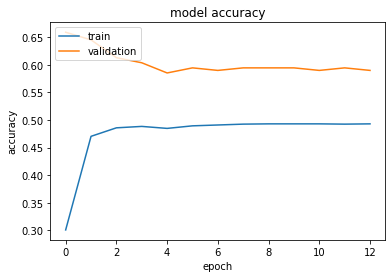

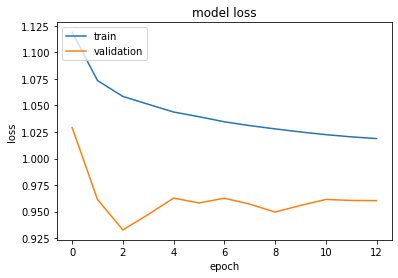

6/6 [==============================] - 0s 2ms/step - loss: 1.2394 - accuracy: 0.3313


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


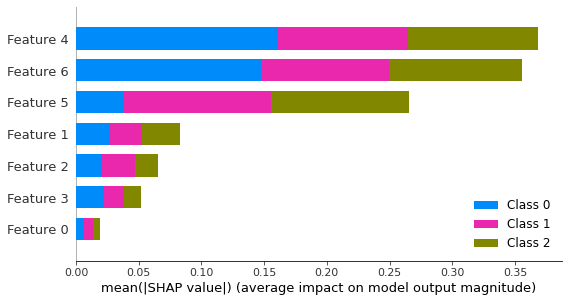

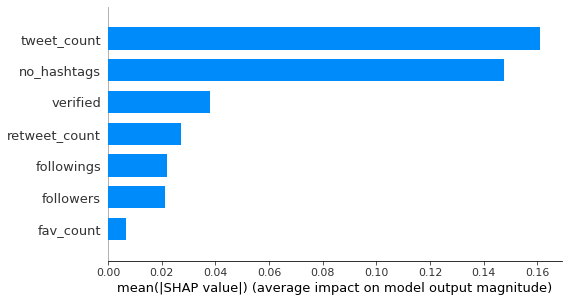

model using as test set:  gurlitt-all-rnr-threads
size of the test set:  549


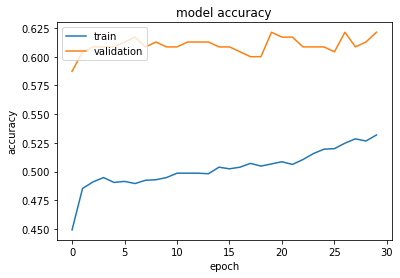

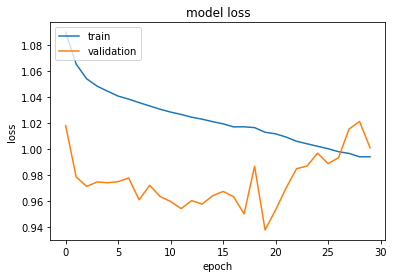

2/2 [==============================] - 0s 4ms/step - loss: 1.4513 - accuracy: 0.0714


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


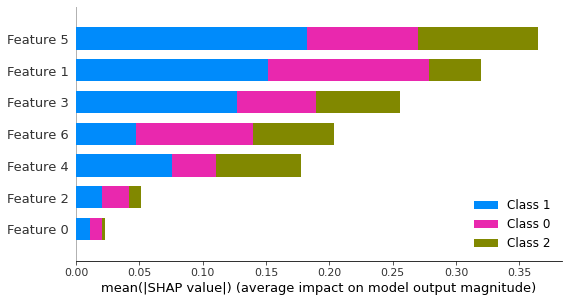

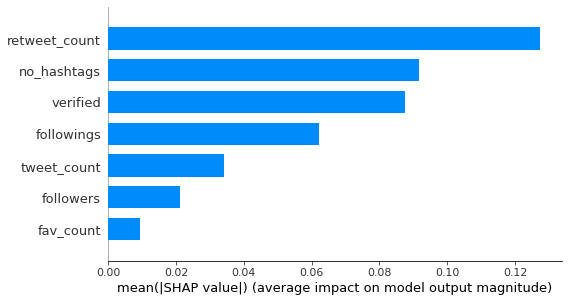

model using as test set:  sydneysiege-all-rnr-threads
size of the test set:  4698


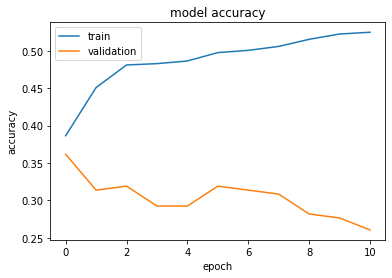

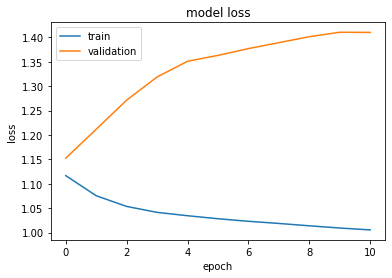

12/12 [==============================] - 0s 2ms/step - loss: 1.1276 - accuracy: 0.5123


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


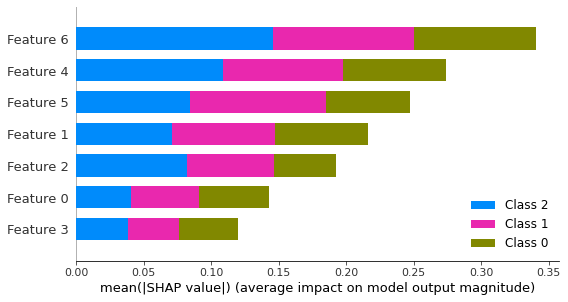

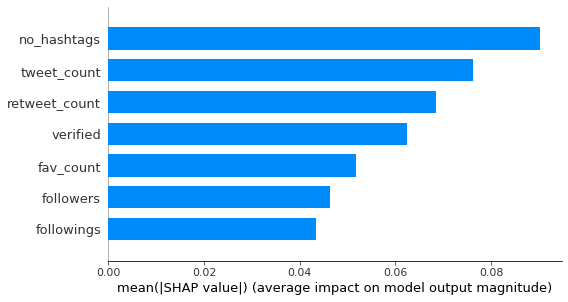

In [20]:
#all features except date & account_data & username

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
lb = LabelBinarizer()
metrics = []
shaps = []

# here we use Leave One Event Out Cross Validation: we test our model on the one event it has never seen during the training
for f in folds:
    
    df_train = df[df['event']!=f]
    df_test = df[df['event']==f]
    
    print('model using as test set: ', f)
    print('size of the test set: ',df_test.size)
    
    # We are trying data from the test also as validation data. The idea is to avoid to learn fact about the events, using train events as validation data ,but just high level patterns.
    # But this method is not right either, beacuse we are overfitting for our test event, so of course it will result in better accuracy
    X_test, X_val, y_test, y_val = train_test_split(df_test[['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']], df_test['target'], test_size=0.3, random_state=0)
    
    X_train = df_train[['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    y_train = df_train['target']

    X_train_static_ns = X_train[['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    X_val_static_ns = X_val[['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    X_test_static_ns = X_test[['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    
    #normalize training folds
    scaler = preprocessing.StandardScaler().fit(X_train_static_ns)
    X_train_static = scaler.transform(X_train_static_ns)
    
    #normalize the validation and test
    X_val_static = scaler.transform(X_val_static_ns)
    X_test_static = scaler.transform(X_test_static_ns)

    y_train = lb.fit_transform(y_train)
    y_val = lb.transform(y_val)
    y_test = lb.transform(y_test)


    static_input_shape = X_train_static.shape[1]
    epochs = 50
    batch_size = 256
    
    model = build_model(static_input_shape)

    history = model.fit([X_train_static], y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.1, 
                        verbose=0,# to see the training, put verbose=1
                        validation_data=([X_val_static, y_val]),
                        callbacks=callback)
    
    # to reduce verbosity we can comment the line below
    plot_history(history)

    metrics.append(model.evaluate([X_test_static], y_test))
    
    # XAI Section

    np_X_train_static = np.asarray(X_train_static)

    np_X_test_static = np.asarray(X_test_static)

    rng = np.random.default_rng()
    shap_train_static = rng.choice(np_X_train_static, size=100, replace=False)
    shap_test_static = rng.choice(np_X_test_static, size=100, replace=True)

    DE = shap.DeepExplainer(model, [shap_train_static])
    shap_values = DE.shap_values([shap_test_static], check_additivity=False)
    shaps.append(shap_values)
    
    #this shows the feature importance for every class
    shap.summary_plot(shap_values)
    

    #this shows the feature importance for the fake class
    shap.initjs()
    shap.summary_plot(
        shap_values[0], 
        shap_test_static,
        feature_names=['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags'],
        max_display=50,
        plot_type='bar')

In [21]:
#Print the average accuracy and standard error
metrics = np.array(metrics)
mean = np.average(metrics[:,1])
std = np.std(metrics[:,1])
print(mean, std)

0.259768261677689 0.16303206771306644


The Shapley values show how important were the features for each model trained. We want to have a general vision of this for all models and also see how this importance can change for every model (that, we remember, is receiving as training set all the tweets of the events in the Pheme dataset except for the one used in the test).

To do so we normalize our score for each model, than we compute the mean and standard deviation.

In [22]:
np_shaps = np.asarray(shaps)
print(np_shaps.shape)

z_shap=stats.zscore(np_shaps,axis=3)

z_shap = np.abs(z_shap)
mean_shap_values = np.mean(z_shap,0)
std_shap = np.std(z_shap,0)
print(std_shap,std_shap.shape)

(9, 3, 100, 7)
[[[0.28724535 0.54041648 0.32332706 ... 0.65045302 0.47770681 0.71789116]
  [0.2771753  0.71483824 0.40907109 ... 0.74426545 0.67885123 0.63085308]
  [0.38381214 0.70297738 0.53351198 ... 0.49785341 0.61867272 0.77164374]
  ...
  [0.25038829 0.50311589 0.5833216  ... 0.58718773 0.44757257 0.42455457]
  [0.20934729 0.70165433 0.30396388 ... 0.62089325 0.65599354 0.60823824]
  [0.26573172 0.6817315  0.29470585 ... 0.49673229 0.49530362 0.64112126]]

 [[0.18549361 0.51025437 0.4166066  ... 0.48657426 0.33320103 0.47511599]
  [0.37617015 0.66545882 0.38989425 ... 0.65451371 0.93394706 0.67579179]
  [0.28424926 0.69407835 0.68343641 ... 0.48999969 0.70089342 0.35475928]
  ...
  [0.21301634 0.36648061 0.29531908 ... 0.58063905 0.61236334 0.4677326 ]
  [0.24819455 0.58797957 0.26055578 ... 0.60335174 0.73305685 0.58885211]
  [0.334191   0.44890438 0.19115501 ... 0.59979    0.67245195 0.64020973]]

 [[0.15900123 0.35224117 0.38535251 ... 0.35383029 0.5131356  0.5722802 ]
  [0.45

In [23]:
#to better present the data we order them for mean value

column_names = ['likes count','retweets','followers','followings','tweet count','verified','n° hashtags']

df_shap= pd.DataFrame([np.mean(mean_shap_values[0],0),np.mean(std_shap[0],0)], index= ['mean', 'std'],columns=column_names)
print(df_shap)

ord_shap = df_shap.sort_values(by = ['mean'], axis = 1, ascending = False)

      likes count  retweets  followers  followings  tweet count  verified  \
mean     0.362616  0.806337   0.521454    0.439737     0.980965  1.027109   
std      0.302567  0.654421   0.435664    0.393345     0.574448  0.654979   

      n° hashtags  
mean     1.189029  
std      0.595805  


<BarContainer object of 7 artists>

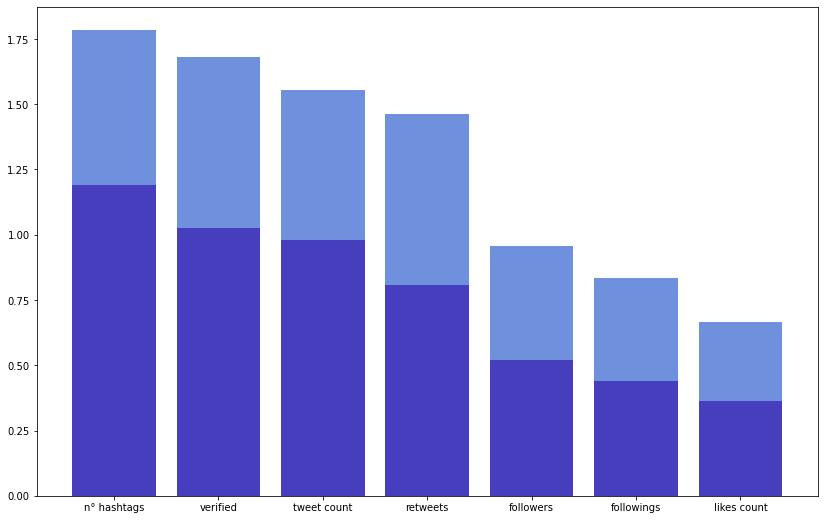

In [25]:
# here we plot the mean and standard deviation 

plt.rcParams["figure.figsize"] = (14, 9)

plt.bar(ord_shap.columns, ord_shap.iloc[0], color="#463ebd")
plt.bar(ord_shap.columns, ord_shap.iloc[1], bottom=ord_shap.iloc[0], color="#6f91dd")

In light blue, you can see the std, and in dark blue the mean. This helps us understand that the ranking can easily change between events. This is another hint for the conclusion that the **structure of a fake news can change a lot in text and social interaction depending on which event are we talking about.** 